[Reference] Richard S. Sutton and Andrew G. Barto, **Reinforcement Learning: An Introduction**, [2nd Edition.](http://incompleteideas.net/book/the-book-2nd.html), 2018.

> All codes were rewritten by [Jin-Hwan CHO](https://chof.icim.or.kr/aboutme/) based on [ShangtongZhang/reinforcement-learning-an-introduction
](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction).

# Chapter 2. Multi-armed Bandits

### A $k$-armed bandit problem

- You are faced repeatedly with a choice among $k$ different options (or **actions**).
- After each choice you receive a numerical **reward** chosen from a *stationary probability distribution* (e.g., normal distribution) that depends on the action you selected.
- Your objective is to *maximize the expected total reward* over some **time steps** (e.g., over 1000 action selections).

### (True) action value $q_*(a)$

Each of the $k$ actions has an expected or mean reward (called the **action value**) given that that action is selected:
$$ q_*(a) := \mathbb{E}[R_t\mid A_t=a] $$
where $A_t$ is the action selected on time step $t$, and $R_t$ is the corresponding reward.
    
  - If you knew $q_*(a)$, then it would be trivial to solve the $k$-armed bandit problem: you would always select the action with highest value.
  - We assume that you do *not* know the action values with certainty.

### Estimated action value $Q_t(a)$

We would like the estimated value $Q_t(a)$ of action $a$ at time step $t$ to be close to $q_*(a)$.
  - (**The sample-average method**) One natural way to estimate this is by averaging the rewards actually received:
    $$
Q_t(a) := \frac{\text{sum of rewards when $a$ taken prior to $t$}}{\text{number of times $a$ taken prior to $t$}}
= \frac{\sum_{i=1}^{t-1}R_i\cdot\mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}},
\tag{2.1}
    $$
  - Note that $Q_t(a)\to q_∗(a)$ as the denominator goes to $\infty$ (not $t\to\infty$).

### Action selection rule

  - (**The greedy method**; no exploration) Select one of the actions with the highest estimated value:
    $$ A_t := \operatorname{argmax}_a Q_t(a) $$
    with tie-breaking randomly.
  - (**The $\epsilon$-greedy method**; $\epsilon$ exploration and $1-\epsilon$ exploitation) Behave greedily most of the time, but every once in a while (with small probability $\epsilon$) instead select randomly from among all the actions with equal probability, independently of the action-value estimates.
    - An advantage of these methods is that $Q_t(a)\to q_∗(a)$ for all $a$ as $t\to\infty$.
    
### Incremental implementation

To simplify notation we concentrate on a single action.
  - Let $R_i$ denote the reward received after the $i$th selection *of this action*, and let $Q_n$ denote the estimate of its action value after it has been selected $n−1$ times:
    $$ Q_n := \frac{R_1+R_2+\dotsb+R_{n-1}}{n-1} $$
  - Given $Q_n$ and the $n$th reward, $R_n$, the new average of all $n$ rewards can be computed by
    $$
    Q_{n+1} := \frac{1}{n}\sum_{i=1}^n R_i = \frac{1}{n}(R_n+(n-1)Q_n) = Q_n +\frac{1}{n}[R_n-Q_n] \tag{2.3}
    $$
    The general form is
    $$
    \text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} [\text{Target}-\text{OldEstimate}] \tag{2.4}
    $$

Pseudocode for a complete bandit algorithm using incrementally computed sample averages and $\epsilon$-greedy action selection is shown in below. The function `bandit(a)` is assumed to take an action and return a corresponding reward.
    ![A simple bandit algorithm](images/a_simple_bandit_algorithm.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import repeat
from tqdm import trange

%matplotlib inline

In [2]:
class SimpleBandit(object):
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    def __init__(self, kArm=10, epsilon=0., initial=0.):
        self.k = kArm
        self.epsilon = epsilon
        self.initial = initial
 
        self.averageReward = 0.
        self.time = 0

        # each bandit has its own random state with seed=None
        self.randomState = np.random.RandomState()
        
        # true action value $q_*(a)$
        self.qTrue = self.randomState.standard_normal(self.k)
        self.bestAction = np.argmax(self.qTrue) # assume no tie

        # estimated action value $Q_t(a)$ with initial value
        self.qEst = np.zeros(self.k) + self.initial

        # # of chosen times $N(a)$ for each action
        self.actionCount = np.zeros(self.k, dtype=int)

    # (tie-breaking randomly) argmax
    def randargmax(self, a):
        return self.randomState.choice(np.flatnonzero(a == a.max()))
    
    # get an action for this bandit, explore or exploit?
    def getAction(self):
        # explore
        if self.epsilon > 0.:
            if self.randomState.binomial(1, self.epsilon) == 1:
                return self.randomState.choice(self.k)
        # exploit (tie-breaking randomly)
        return self.randargmax(self.qEst)

    # take an action, update estimation for this action
    def takeAction(self, action):
        # generate the reward under N(true action value, 1)
        reward = self.randomState.normal(self.qTrue[action], 1.)
        self.time += 1
        self.averageReward = (self.time - 1.) / self.time * self.averageReward + \
                             reward / self.time
        self.actionCount[action] += 1
        # update estimation using sample averages
        self.qEst[action] += 1. / self.actionCount[action] * \
                             (reward - self.qEst[action])
        return reward

Best action 9 among the true rewards
[-8.83214044e-01 -8.21076973e-02 -3.99266283e-01 -2.25448910e-03
 -1.67924573e+00 -5.13944574e-01  1.64635031e-01 -7.08558085e-01
  1.26917765e+00  2.52714974e+00]


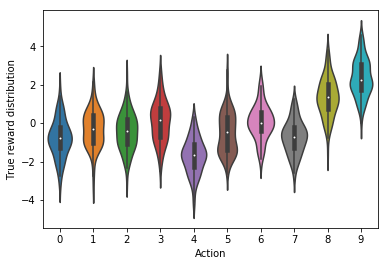

In [3]:
b = SimpleBandit()
print("Best action {} among the true rewards\n{}".format(b.bestAction, b.qTrue))

plt.subplots()
ax = sns.violinplot(data=b.randomState.normal(b.qTrue, 1., (100, b.k)))
ax.set_xlabel("Action")
ax.set_ylabel("True reward distribution");
plt.show()

> **Figure 2.1:** An example bandit problem from the 10-armed testbed. The true value $q_*(a)$ of
each of the ten actions was selected according to a normal distribution with mean zero and unit
variance, and then the actual rewards were selected according to a mean $q_*(a)$ unit variance
normal distribution, as suggested by these gray distributions.

In [8]:
b = SimpleBandit(epsilon=0.1)
print("Best action {} among the true rewards\n{}".format(b.bestAction, b.qTrue))

for _ in repeat(None, 100):
    a = b.getAction()
    r = b.takeAction(a)
    print("Time {:3d}: chosen action {} and reward {:6.3f} => Q({})={:6.3f}"
          .format(b.time, a, r, a, b.qEst[a]))

Best action 5 among the true rewards
[-1.82745993 -0.36688023 -0.11652563 -0.20369493 -0.67708249  2.15347117
  1.38212933 -0.21063942 -0.01050187 -0.45547537]
Time   1: chosen action 6 and reward  1.120 => Q(6)= 1.120
Time   2: chosen action 6 and reward  0.210 => Q(6)= 0.665
Time   3: chosen action 6 and reward  0.109 => Q(6)= 0.480
Time   4: chosen action 6 and reward  1.021 => Q(6)= 0.615
Time   5: chosen action 6 and reward  1.246 => Q(6)= 0.741
Time   6: chosen action 6 and reward  0.919 => Q(6)= 0.771
Time   7: chosen action 6 and reward  1.107 => Q(6)= 0.819
Time   8: chosen action 5 and reward  1.942 => Q(5)= 1.942
Time   9: chosen action 5 and reward  3.226 => Q(5)= 2.584
Time  10: chosen action 5 and reward  2.861 => Q(5)= 2.676
Time  11: chosen action 5 and reward  2.728 => Q(5)= 2.689
Time  12: chosen action 5 and reward  2.710 => Q(5)= 2.693
Time  13: chosen action 5 and reward  1.243 => Q(5)= 2.451
Time  14: chosen action 5 and reward  1.408 => Q(5)= 2.302
Time  15: chos

In [10]:
# Serial processing
def banditSimulation(dBandits, time):
    # @dBandits: a dictionary of bandit lists of length nBandits
    bestActionCounts = {}
    averageRewards = {}
    for k, bandits in dBandits.items():
        bestActionCounts[k] = np.zeros(time)
        averageRewards[k] = np.zeros(time)
        for i in trange(len(bandits)):
            for t in range(time):
                action = bandits[i].getAction()
                reward = bandits[i].takeAction(action)
                averageRewards[k][t] += reward
                if action == bandits[i].bestAction:
                    bestActionCounts[k][t] += 1
        bestActionCounts[k] /= len(bandits)
        averageRewards[k] /= len(bandits)
    return bestActionCounts, averageRewards

In [11]:
nBandits = 500
time = 1000

# Generate 500 bandits for each epsilon
dBandits = {}
for e in [0, 0.1]:
    dBandits[e] = [SimpleBandit(epsilon=e) for _ in range(nBandits)]

%time fig22_bac, fig22_avr = banditSimulation(dBandits, time)

100%|██████████| 500/500 [00:30<00:00, 16.51it/s]

CPU times: user 56.7 s, sys: 10.6 s, total: 1min 7s
Wall time: 57.8 s


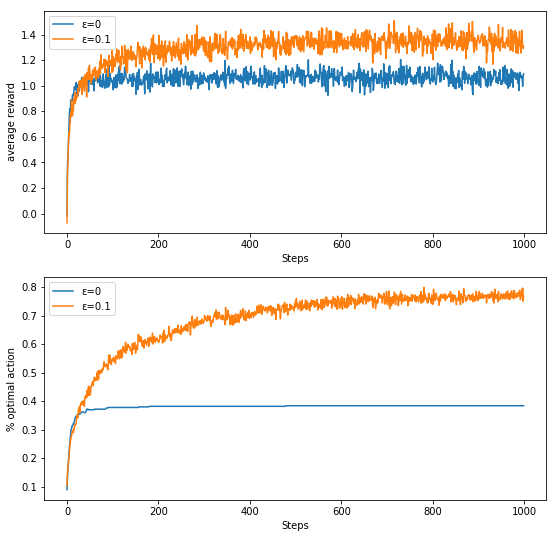

In [12]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,9))

for e in fig22_avr:
    ax1.plot(fig22_avr[e], label='ε={}'.format(e))
    ax2.plot(fig22_bac[e], label='ε={}'.format(e))

ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

In [13]:
# Parallel processing (requires many cores)
from multiprocessing import Pool

def runBandit(bandit, time):
    avr = np.zeros(time)
    bac = np.zeros(time, dtype=int)
    for t in range(time):
        action = bandit.getAction()
        reward = bandit.takeAction(action)
        avr[t] = reward
        if action == bandit.bestAction:
            bac[t] = 1
    return bac, avr

def multiBanditSimulation(dBandits, t):
    # @dBandits: a dictionary of bandit lists of length nBandits
    bestActionCounts = {}
    averageRewards = {}    
    for k, bandits in dBandits.items():
        bestActionCounts[k] = np.zeros(time)
        averageRewards[k] = np.zeros(time)
        with Pool(processes=None) as pool:
            # with Pool.apply_async()
            result = [pool.apply_async(runBandit, (bandits[i], time))
                      for i in range(len(bandits))]
            result = np.asarray([r.get() for r in result])
            # with Pool.starmap_async()
            #from itertools import zip_longest
            #result = pool.starmap_async(runBandit, zip_longest(bandits, [time], fillvalue=time))
            #result = np.asarray(result.get())
        bestActionCounts[k] = result[:,0,:].mean(axis=0)
        averageRewards[k] = result[:,1,:].mean(axis=0)
    return bestActionCounts, averageRewards

In [14]:
nBandits = 2000
time = 1000

# Generate 2000 bandits for each epsilon
dBandits = {}
for e in [0, 0.1, 0.01]:
    dBandits[e] = [SimpleBandit(epsilon=e) for _ in range(nBandits)]

%time fig22_bac, fig22_avr = multiBanditSimulation(dBandits, time)

CPU times: user 2.67 s, sys: 2.86 s, total: 5.53 s
Wall time: 8.74 s


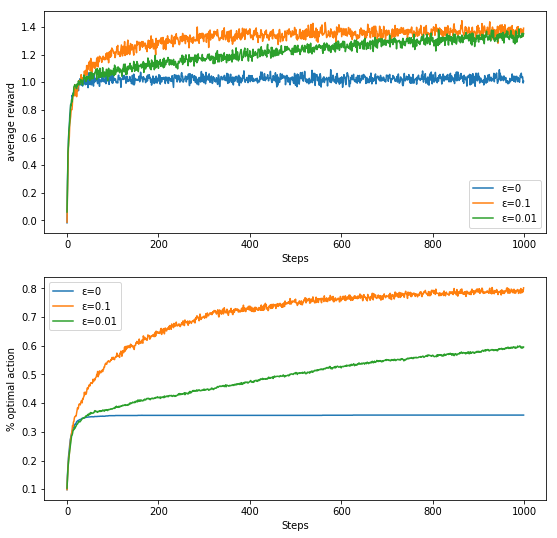

In [15]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,9))

for e in fig22_avr:
    ax1.plot(fig22_avr[e], label='ε={}'.format(e))
    ax2.plot(fig22_bac[e], label='ε={}'.format(e))

ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

> **Figure 2.2:** Average performance of $\epsilon$-greedy action-value methods on the 10-armed testbed.
These data are averages over 2000 runs with different bandit problems. All methods used sample
averages as their action-value estimates.

### Optimistic initial values

Optimistic initial values can be used as a simple way to *encourage* exploration.
  - We regard it as a simple trick that can be quite effective on stationary problems, but it is far from being a generally useful approach to encouraging exploration.
  - For example, it is not well suited to nonstationary problems because its drive for exploration is inherently temporary.

In [16]:
nBandits = 2000
time = 1000

dBandits = {}
dBandits[0] = [SimpleBandit(epsilon=0.1, initial=0) for _ in range(nBandits)]
dBandits[1] = [SimpleBandit(epsilon=0.1, initial=5) for _ in range(nBandits)]
dBandits[2] = [SimpleBandit(epsilon=0, initial=5) for _ in range(nBandits)]

%time fig23_bac, fig23_avr = multiBanditSimulation(dBandits, time)

CPU times: user 2.56 s, sys: 4.79 s, total: 7.35 s
Wall time: 10.5 s


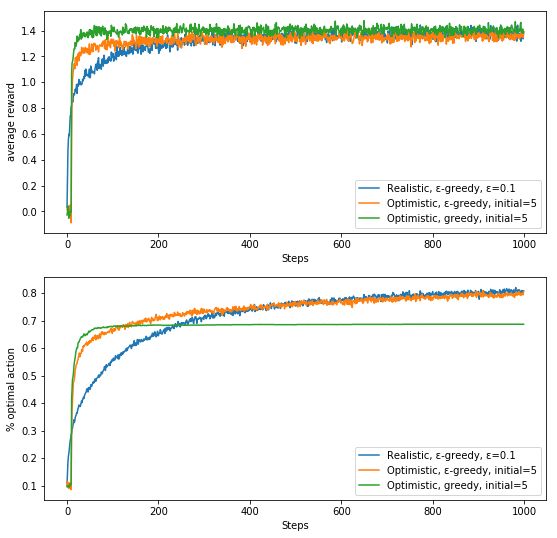

In [17]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,9))

ax1.plot(fig23_avr[0], label='Realistic, ε-greedy, ε=0.1')
ax1.plot(fig23_avr[1], label='Optimistic, ε-greedy, initial=5')
ax1.plot(fig23_avr[2], label='Optimistic, greedy, initial=5')
ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.plot(fig23_bac[0], label='Realistic, ε-greedy, ε=0.1')
ax2.plot(fig23_bac[1], label='Optimistic, ε-greedy, initial=5')
ax2.plot(fig23_bac[2], label='Optimistic, greedy, initial=5')
ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

### Tracking a nonstationary problem

The averaging methods discussed so far are appropriate for *stationary* bandit problems, that is, for bandit problems in which the reward probabilities do not change over time.
  - One of the most popular ways of giving more weight to recent rewards than to long-past rewards is to use a *constant* step-size parameter $\alpha\in(0,1]$:
  $$
  Q_{n+1} := Q_n + \alpha [R_n - Q_n] \tag{2.5}
  $$
  
  - (**Exponential recency-weighted average**) This results in $Q_{n+1}$ being a weighted average of past rewards and the initial estimate $Q_1$:
  $$
  Q_{n+1} = \alpha R_n + (1-\alpha) Q_n = (1-\alpha)^n Q_1 + \sum_{i=1}^n \alpha(1-\alpha)^{n-i} R_i \tag{2.6}
  $$

In [18]:
class Bandit(SimpleBandit):
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @stepSize: constant step size for updating estimations
    # @sampleAverages: if True, use sample averages to update estimations instead of constant step size
    def __init__(self, stepSize=0.1, sampleAverages=False, **kwargs):
        super().__init__(**kwargs)

        self.stepSize = stepSize
        self.sampleAverages = sampleAverages

    # take an action, update estimation for this action
    def takeAction(self, action):
        # generate the reward under N(real reward, 1)
        reward = self.randomState.normal(self.qTrue[action], 1.)
        self.time += 1
        self.averageReward = (self.time - 1.) / self.time * self.averageReward + \
                             reward / self.time
        self.actionCount[action] += 1
        if self.sampleAverages:
            # update estimation using sample averages
            self.qEst[action] += 1. / self.actionCount[action] * \
                                 (reward - self.qEst[action])
        else:
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

In [19]:
nBandits = 2000
time = 1000

dBandits = {}
dBandits[0] = [Bandit(epsilon=0.1, initial=0) for _ in range(nBandits)]
dBandits[1] = [Bandit(epsilon=0, initial=5) for _ in range(nBandits)]
dBandits[2] = [Bandit(epsilon=0.1, initial=5) for _ in range(nBandits)]

%time fig23_bac, fig23_avr = multiBanditSimulation(dBandits, time)

CPU times: user 2.63 s, sys: 4.66 s, total: 7.29 s
Wall time: 9.79 s


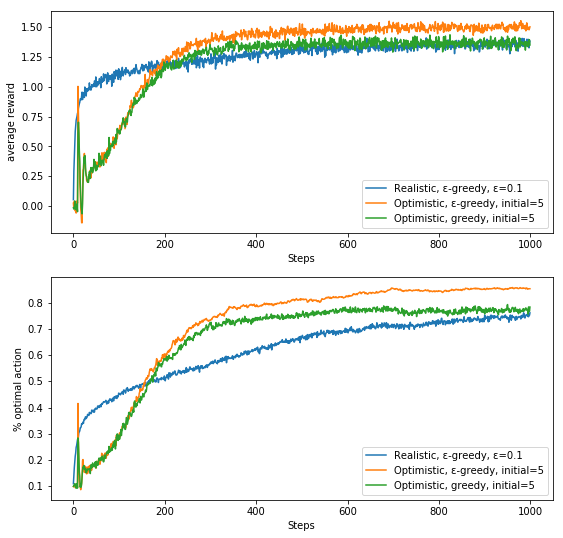

In [20]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,9))

ax1.plot(fig23_avr[0], label='Realistic, ε-greedy, ε=0.1')
ax1.plot(fig23_avr[1], label='Optimistic, ε-greedy, initial=5')
ax1.plot(fig23_avr[2], label='Optimistic, greedy, initial=5')
ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.plot(fig23_bac[0], label='Realistic, ε-greedy, ε=0.1')
ax2.plot(fig23_bac[1], label='Optimistic, ε-greedy, initial=5')
ax2.plot(fig23_bac[2], label='Optimistic, greedy, initial=5')
ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

> **Figure 2.3:** The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods used a constant step-size parameter, $\alpha=0.1$.

In [21]:
class NonStationaryBandit(Bandit):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def takeAction(self, action):
        # true action value changes for each action: increment with N(0,0.01) distribution
        self.qTrue += self.randomState.normal(0., 0.01, self.k)
        self.bestAction = np.argmax(self.qTrue) # assume no tie
        return super().takeAction(action)

In [22]:
nBandits = 2000
time = 10000

dBandits = {}
dBandits[0] = [NonStationaryBandit(epsilon=0.1, sampleAverages=True) for _ in range(nBandits)]
dBandits[1] = [NonStationaryBandit(epsilon=0.1, stepSize=0.1) for _ in range(nBandits)]

%time ex25_bac, ex25_avr = multiBanditSimulation(dBandits, time)

CPU times: user 2.64 s, sys: 4.71 s, total: 7.34 s
Wall time: 1min 15s


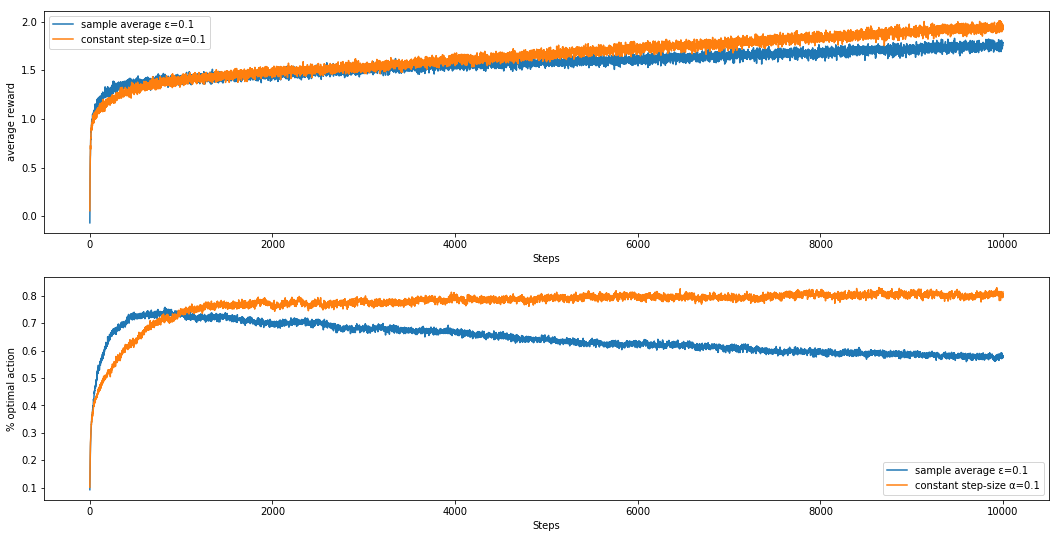

In [23]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18,9))

ax1.plot(ex25_avr[0], label='sample average ε=0.1')
ax1.plot(ex25_avr[1], label='constant step-size α=0.1')
ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.plot(ex25_bac[0], label='sample average ε=0.1')
ax2.plot(ex25_bac[1], label='constant step-size α=0.1')
ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

###  UCB (Upper Confidence Bound) action selection

  - Exploration is needed because there is always uncertainty about the accuracy of $Q_t(a)$. 
  - $\epsilon$-greedy action selection forces the non-greedy actions to be tried, but indiscriminately.
  - It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates.

One effective way of doing this is to select actions according to
    $$
    A_t := \operatorname{argmax}_a \left[ Q_t(a) + c\sqrt{\frac{\ln t}{N_t(a)}} \right] \tag{2.10}
    $$
    
  - The square-root term is a measure of the uncertainty or variance in the estimate of $a$’s value.
  - The quantity being max’ed over is thus a sort of upper bound on the possible true value of action $a$, with $c$ determining the confidence level.
  - Each time $a$ is selected the uncertainty is presumably reduced. On the other hand, each time an action other than $a$ is selected, the uncertainty estimate increases.
  - The use of the natural logarithm means that the increases get smaller over time, but are unbounded; all actions will eventually be selected, but actions with lower value estimates, or that have already been selected frequently, will be selected with decreasing frequency over time.

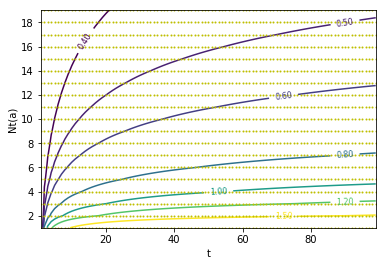

In [24]:
_, ax = plt.subplots()

t = np.arange(1., 100.)
n = np.arange(1., 20.)
X, Y = np.meshgrid(t, n)
Z = np.sqrt(np.log(X) / Y)

ax.plot(X, Y, 'yo', ms=1)
CS = ax.contour(X, Y, Z, levels=[.4, .5, .6, .8, 1.0, 1.2, 1.5])
ax.set_xlabel('t')
ax.set_ylabel('Nt(a)')
ax.clabel(CS, inline=1, fontsize=8, fmt='%1.2f')

plt.show()

In [25]:
class UCBBandit(Bandit):
    # @UCBParam: if not None, use UCB algorithm to select action
    def __init__(self, UCBParam=None, **kwargs):
        super().__init__(**kwargs)

        self.UCBParam = UCBParam
        
    def getAction(self):
        # explore
        if self.epsilon > 0.:
            if self.randomState.binomial(1, self.epsilon) == 1:
                return self.randomState.choice(self.k)
        # exploit
        if self.UCBParam:
            return np.argmax(self.qEst + \
                self.UCBParam * np.sqrt(np.log(self.time + 1) / (self.actionCount + 1)))
        else:
            return self.randargmax(self.qEst)

In [26]:
nBandits = 2000
time = 1000

dBandits = {}
dBandits[0] = [UCBBandit(epsilon=.1, stepSize=.1) for _ in range(nBandits)]
dBandits[1] = [UCBBandit(epsilon=0, stepSize=.1, UCBParam=1) for _ in range(nBandits)]
dBandits[2] = [UCBBandit(epsilon=0, stepSize=.1, UCBParam=2) for _ in range(nBandits)]

%time fig24_bac, fig24_avr = multiBanditSimulation(dBandits, time)

CPU times: user 2.61 s, sys: 9.29 s, total: 11.9 s
Wall time: 14.6 s


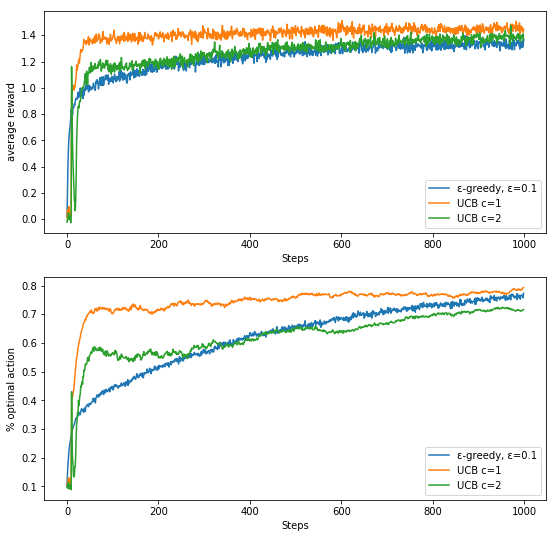

In [27]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,9))

ax1.plot(fig24_avr[0], label='ε-greedy, ε=0.1')
ax1.plot(fig24_avr[1], label='UCB c=1')
ax1.plot(fig24_avr[2], label='UCB c=2')
ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.plot(fig24_bac[0], label='ε-greedy, ε=0.1')
ax2.plot(fig24_bac[1], label='UCB c=1')
ax2.plot(fig24_bac[2], label='UCB c=2')
ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

> **Figure 2.4:** Average performance of UCB action selection on the 10-armed testbed. As shown, UCB generally performs better than $\epsilon$-greedy action selection, except in the first k steps, when it selects randomly among the as-yet-untried actions.

### Gradient bandit algorithms

We consider learning a numerical **action preference** $H_t(a)$ for each action $a$, instead of $Q_t(a)$.
  - (**Soft-max action selection rule**) The larger $H_t(a)$, the more often that action is taken, but $H_t(a)$ has no interpretation in terms of reward. Only the relative preference of one action over another is important; the probability $\pi_t(a)$ of taking action $a$ at time $t$ is given by a *soft-max distribution*:
    $$
    \operatorname{Pr}\{ A_t=a \} := \frac{e^{H_t(a)}}{\sum_{b=1}^ke^{H_t(b)}} := \pi_t(a),
    $$
  - Initially all action preferences are the same (e.g., $H_1(a)=0$, for all $a$) so that all actions have an equal probability of being selected.

There is a natural learning algorithm for $H_t(a)$ based on the idea of **stochastic gradient ascent**:
$$
H_{t+1}(a) := H_t(a) + \alpha\frac{\partial\mathbb{E}[R_t]}{\partial H_t(a)}
$$
where $\mathbb{E}[R_t]=\sum_x \pi_t(x)q_*(x)$.

  - On each step, after selecting action $A_t=a_0$ and receiving the reward $R_t$, the **action preferences** are updated by:
    $$
    H_{t+1}(a_0) := H_t(a_0) + \alpha(R_t-\bar R_t)(1-\pi_t(a_0))
    $$
    and for all $a\neq a_0$,
    $$
    H_{t+1}(a) := H_t(a) - \alpha(R_t-\bar R_t)\pi_t(a)
    $$
    where $\alpha>0$ is a step-size parameter, and $\bar R_t\in\mathbb{R}$ is the average of all the rewards up through and including time $t$, which can be computed incrementally.
  - The $\bar R_t$ term serves as a **baseline** with which the reward is compared. If $R_t>\bar R_t$, then $\operatorname{Pr}\{A_{t+1}=a_0\}=\pi_{t+1}(a_0)$ is increased, and if $R_t<\bar R_t$, then probability is decreased. The non-selected actions $a\neq a_0$ move in the opposite direction.
  
![The Bandit Gradient Algorithm as Stochastic Gradient Ascent](images/the_bandit_gradient_algorithm_as_stochastic_gradient_ascent.png)

In [28]:
class GradientBandit(Bandit):
    # @gradient: if True, use gradient based bandit algorithm
    # @gradientBaseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, gradient=False, gradientBaseline=False, trueReward=0., **kwargs):
        super().__init__(**kwargs)

        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        self.trueReward = trueReward

        # true action value for each action: initialize with N(0,1) distribution
        self.qTrue = self.randomState.normal(self.trueReward, 1., self.k)
        self.bestAction = np.argmax(self.qTrue) # Assume no tie

    def getAction(self):
        # explore
        if self.epsilon > 0.:
            if self.randomState.binomial(1, self.epsilon) == 1:
                return self.randomState.choice(self.k)
        # exploit
        if self.gradient:
            expEst = np.exp(self.qEst)
            self.actionProb = expEst / np.sum(expEst) # soft-max distribution
            return self.randomState.choice(self.k, p=self.actionProb)
        else:
            return self.randargmax(self.qEst)

    def takeAction(self, action):
        # generate the reward under N(real reward, 1)
        reward = self.randomState.normal(self.qTrue[action], 1.)
        self.time += 1
        self.averageReward = (self.time - 1.) / self.time * self.averageReward + \
                             reward / self.time
        self.actionCount[action] += 1
        if self.sampleAverages:
            self.qEst[action] += 1. / self.actionCount[action] * \
                                 (reward - self.qEst[action])
        elif self.gradient:
            oneHot = np.zeros(self.k)
            oneHot[action] = 1.
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0
            self.qEst += self.stepSize * (reward - baseline) \
                                       * (oneHot - self.actionProb)
        else:
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

In [29]:
nBandits = 2000
time = 1000

dBandits = {}
dBandits[0] = [GradientBandit(stepSize=.1, gradient=True, gradientBaseline=True, trueReward=4.)
                   for _ in range(nBandits)]
dBandits[1] = [GradientBandit(stepSize=.1, gradient=True, gradientBaseline=False, trueReward=4.)
                   for _ in range(nBandits)]
dBandits[2] = [GradientBandit(stepSize=.4, gradient=True, gradientBaseline=True, trueReward=4.)
                   for _ in range(nBandits)]
dBandits[3] = [GradientBandit(stepSize=.4, gradient=True, gradientBaseline=False, trueReward=4.)
                   for _ in range(nBandits)]

%time fig25_bac, fig25_avr = multiBanditSimulation(dBandits, time)

CPU times: user 3.7 s, sys: 13.3 s, total: 17 s
Wall time: 37.5 s


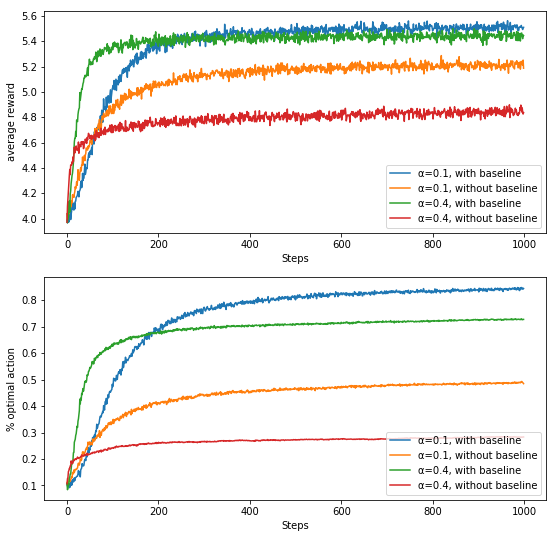

In [30]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,9))

labels = [ 'α=0.1, with baseline', 'α=0.1, without baseline',
    'α=0.4, with baseline', 'α=0.4, without baseline' ]

for i in range(len(fig25_avr)):
    ax1.plot(fig25_avr[i], label=labels[i])
    ax2.plot(fig25_bac[i], label=labels[i])

ax1.set_xlabel('Steps')
ax1.set_ylabel('average reward')
ax1.legend()

ax2.set_xlabel('Steps')
ax2.set_ylabel('% optimal action')
ax2.legend()

plt.show()

> **Figure 2.5:** Average performance of the gradient bandit algorithm with and without a reward baseline on the 10-armed testbed when the $q_∗(a)$ are chosen to be near +4 rather than near zero.

![](images/figure_2.6.png)

> **Figure 2.6:** A parameter study of the various bandit algorithms presented in this chapter. Each point is the average reward obtained over 1000 steps with a particular algorithm at a particular setting of its parameter.